# 1. Import libraries and dataset

In [ ]:
!pip install scikit-plot

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c titanic
! unzip titanic.zip

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score, classification_report

In [103]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA & pre-processing

## EDA

In [69]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


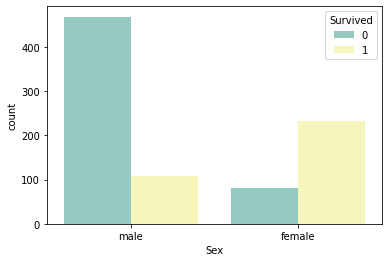

In [71]:
sns.countplot(x="Sex", hue="Survived", data=train, palette='Set3')

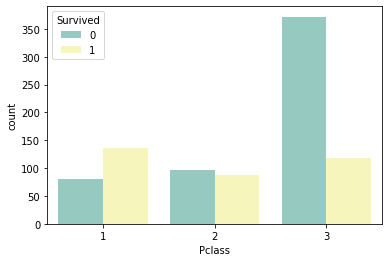

In [72]:
sns.countplot(x="Pclass", hue="Survived", data=train, palette='Set3')

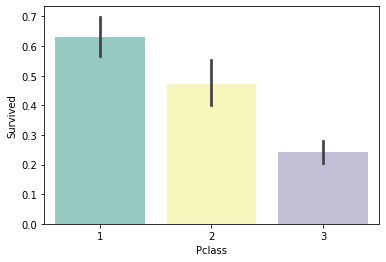

In [73]:
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')

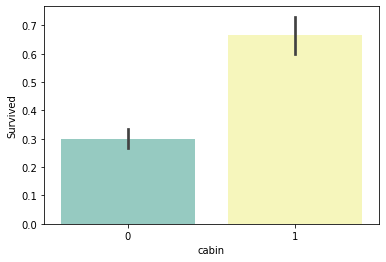

In [74]:
train['cabin'] = train['Cabin'].apply(lambda x: 1 if pd.notnull(x) else 0).astype('int')
sns.barplot(x="cabin", y="Survived", data=train, palette='Set3')

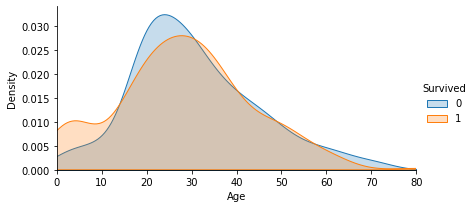

In [75]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

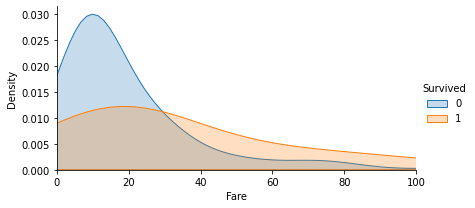

In [76]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 100))
facet.add_legend()

In [104]:
train['Title'] = train['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
titles = train.Title.value_counts().to_frame()
titles.reset_index(inplace=True)
titles

,index,Title
0,Mr,517
1,Miss,182
2,Mrs,125
3,Master,40
4,Dr,7
5,Rev,6
6,Mlle,2
7,Major,2
8,Col,2
9,the Countess,1


In [105]:
Title_Dictionary = {
    "Capt": 1,
    "Col": 1,
    "Major": 1,
    "Dr": 1,
    "Rev": 1,
    "Don": 2,
    "Dona": 2,
    "Sir" : 2,
    "the Countess":2,
    "Lady" : 2,
    "Mme": 3,
    "Ms": 3,
    "Mrs" : 3,
    "Mr" : 4,
    "Miss" : 5,
    "Mlle": 5,
    "Master" : 6,
    "Jonkheer": 6,
}

In [106]:
train['Title'] = train['Title'].apply(lambda x: Title_Dictionary[x])
titles = train.Title.value_counts().to_frame()
titles.reset_index(inplace=True)
titles

,index,Title
0,4,517
1,5,184
2,3,127
3,6,41
4,1,18
5,2,4


In [107]:
avg_age = dict(round(train.groupby(['Title'])['Age'].mean(),4))
avg_ageS = pd.Series(dict(round(train.groupby(['Title'])['Age'].mean(),4)), name='AVG')
avg_ageS

1    46.7059
2    42.5000
3    35.7182
4    32.3681
5    21.8041
6     5.4776
Name: AVG, dtype: float64

## Preprocessing

In [176]:
def preprocessing(dataset):
  
  dataset['sex'] = dataset['Sex'].apply(lambda x: 1 if x == 'male' else 0).astype('int')
  dataset['embark'] = dataset['Embarked'].apply(lambda x: 0 if x =='S' else(1 if x == 'C' else '2')).astype('int')
  dataset['cabin'] = dataset['Cabin'].apply(lambda x: 1 if pd.notnull(x) else 0).astype('int')

  dataset['Title'] = dataset['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
  dataset['Title'] = dataset['Title'].apply(lambda x: Title_Dictionary[x])

  avg_age = dict(round(train.groupby(['Title'])['Age'].mean(),4))
  for i in avg_age:
    dataset['Age'].loc[(dataset.Title==i) & (dataset.Age.isna())]=avg_age[i]

  for n in ['Name', 'Cabin', 'Ticket', 'Sex', 'Embarked']:
    dataset.drop(n, axis=1, inplace = True)

  return dataset

In [177]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [178]:
train = preprocessing(train)
test = preprocessing(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [179]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   sex          891 non-null    int64  
 8   embark       891 non-null    int64  
 9   cabin        891 non-null    int64  
 10  Title        891 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 76.7 KB


In [180]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   sex          418 non-null    int64  
 7   embark       418 non-null    int64  
 8   cabin        418 non-null    int64  
 9   Title        418 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 32.8 KB


In [181]:
avg_fare = dict(round(train.groupby(['Pclass'])['Fare'].mean(),4))
for i in avg_fare:
    test['Fare'].loc[(test.Pclass==i) & (test.Fare.isna())]=avg_age[i]

In [182]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   sex          418 non-null    int64  
 7   embark       418 non-null    int64  
 8   cabin        418 non-null    int64  
 9   Title        418 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 32.8 KB


In [183]:
train.head(5)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex,embark,cabin,Title
0,1,0,3,22.0,1,0,7.2500,1,0,0,4
1,2,1,1,38.0,1,0,71.2833,0,1,1,3
2,3,1,3,26.0,0,0,7.9250,0,0,0,5
3,4,1,1,35.0,1,0,53.1000,0,0,1,3
4,5,0,3,35.0,0,0,8.0500,1,0,0,4


In [184]:
yData = train.pop('Survived').to_numpy()
xData = train.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(xData, yData, test_size = .2, 
                                                    stratify=yData, shuffle=True, random_state = 42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((712, 10), (712,), (179, 10), (179,))

# XGBoost

In [185]:
param_grid = {
    'n_estimators': [100, 200, 500, 800], 
    'learning_rate': [0.001, 0.01, 0.1, 0.3]
    }

xgb = XGBClassifier()
xgb_grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', verbose = 3)
xgb_grid.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.001, n_estimators=100;, score=0.803 total time=   0.0s
[CV 2/3] END learning_rate=0.001, n_estimators=100;, score=0.806 total time=   0.0s
[CV 3/3] END learning_rate=0.001, n_estimators=100;, score=0.806 total time=   0.0s
[CV 1/3] END learning_rate=0.001, n_estimators=200;, score=0.803 total time=   0.1s
[CV 2/3] END learning_rate=0.001, n_estimators=200;, score=0.806 total time=   0.1s
[CV 3/3] END learning_rate=0.001, n_estimators=200;, score=0.810 total time=   0.1s
[CV 1/3] END learning_rate=0.001, n_estimators=500;, score=0.803 total time=   0.2s
[CV 2/3] END learning_rate=0.001, n_estimators=500;, score=0.814 total time=   0.2s
[CV 3/3] END learning_rate=0.001, n_estimators=500;, score=0.814 total time=   0.2s
[CV 1/3] END learning_rate=0.001, n_estimators=800;, score=0.803 total time=   0.3s
[CV 2/3] END learning_rate=0.001, n_estimators=800;, score=0.814 total time=   0.3s
[CV 3/3] END le

GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'n_estimators': [100, 200, 500, 800]},
             scoring='accuracy', verbose=3)

In [186]:
print(xgb_grid.best_params_)

{'learning_rate': 0.01, 'n_estimators': 800}


In [187]:
final_xgb = XGBClassifier(learning_rate=0.01, n_estimators=800)
eval_set = [(x_train, y_train), (x_test, y_test)]
final_xgb.fit(x_train, y_train, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
final_xgb_label_pred = final_xgb.predict(x_test)

[0]	validation_0-error:0.164326	validation_0-logloss:0.688201	validation_1-error:0.217877	validation_1-logloss:0.689236
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.164326	validation_0-logloss:0.683357	validation_1-error:0.217877	validation_1-logloss:0.685283
[2]	validation_0-error:0.164326	validation_0-logloss:0.678602	validation_1-error:0.217877	validation_1-logloss:0.681413
[3]	validation_0-error:0.164326	validation_0-logloss:0.673939	validation_1-error:0.217877	validation_1-logloss:0.677622
[4]	validation_0-error:0.164326	validation_0-logloss:0.669361	validation_1-error:0.217877	validation_1-logloss:0.673913
[5]	validation_0-error:0.164326	validation_0-logloss:0.664871	validation_1-error:0.217877	validation_1-logloss:0.670276
[6]	validation_0-error:0.164326	validation_0-logloss:0.660467	validation_1-error:0.217877	validation_1-logloss:0.66

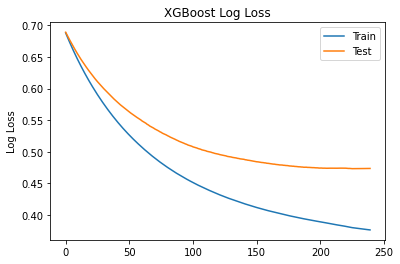

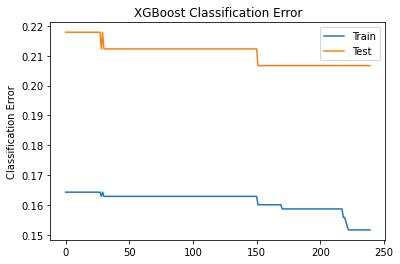

In [188]:
results = final_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [189]:
xgb_acc = accuracy_score(y_test, final_xgb_label_pred)
print("Accuracy for XGBoost on test set: {:.3f}".format(xgb_acc))

print(f"Classification report for classifier XGBoost:\n"
      f"{classification_report(y_test, final_xgb_label_pred)}")

Accuracy for XGBoost on test set: 0.793
Classification report for classifier XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       110
           1       0.83      0.58      0.68        69

    accuracy                           0.79       179
   macro avg       0.81      0.75      0.77       179
weighted avg       0.80      0.79      0.78       179



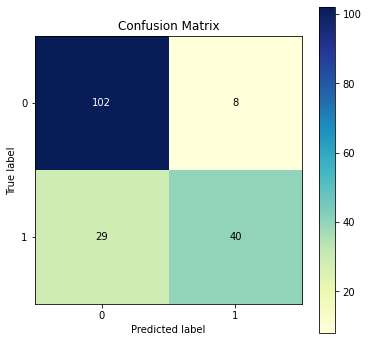

In [190]:
skplt.metrics.plot_confusion_matrix(y_test, final_xgb_label_pred, figsize=(6,6), cmap= 'YlGnBu');

# Random Forest

In [163]:
param_grid = { 
    'n_estimators': [100, 200, 500, 1000],
    'criterion' :['gini', 'entropy'],
    'max_depth' :[1,3,4,5,6,7,8]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose = 3)
rf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV 1/3] END criterion=gini, max_depth=1, n_estimators=100;, score=0.731 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=1, n_estimators=100;, score=0.747 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=1, n_estimators=100;, score=0.759 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=1, n_estimators=200;, score=0.752 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=1, n_estimators=200;, score=0.747 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=1, n_estimators=200;, score=0.759 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=1, n_estimators=500;, score=0.777 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=1, n_estimators=500;, score=0.772 total time=   0.8s
[CV 3/3] END criterion=gini, max_depth=1, n_estimators=500;, score=0.768 total time=   0.8s
[CV 1/3] END criterion=gini, max_depth=1, n_estimators=1000;, score=0.794 total time=   1.6s
[CV 2/3] END crit

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='accuracy', verbose=3)

In [164]:
print(rf_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}


In [173]:
final_rf = RandomForestClassifier(criterion='entropy', n_estimators=200, max_depth=9) 
final_rf.fit(x_train, y_train)
final_rf_label_pred = final_rf.predict(x_test)

rf_acc = accuracy_score(y_test, final_rf_label_pred)
print("Accuracy for Random Forest on test set: {:.3f}".format(rf_acc))

print(f"Classification report for classifier Random Forest:\n"
      f"{classification_report(y_test, final_rf_label_pred)}")

Accuracy for Random Forest on test set: 0.832
Classification report for classifier Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



# Output

In [191]:
test['Survived'] = final_xgb.predict(test.values)
submission = test[['PassengerId','Survived']]
submission.to_csv("submissionxgb.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
